# Processing natural gas prices data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib widget
from datetime import datetime
import numpy as np
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('Nat_Gas.csv')

In [3]:
# Convert dates to datetime if they aren't already
df['Dates'] = pd.to_datetime(df['Dates'])

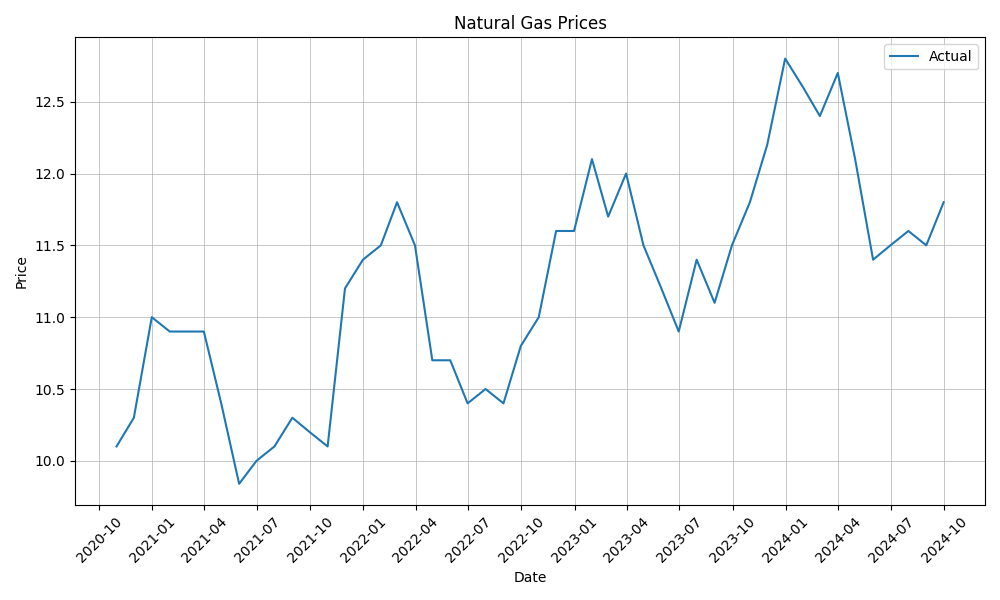

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Convert dates to datetime if not already
df['Dates'] = pd.to_datetime(df['Dates'])

# Plot data
ax.plot(df['Dates'], df['Prices'], label='Actual')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')

# Format x-axis to show dates properly
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM
plt.xticks(rotation=45)

# Add grid
ax.grid(linestyle='-', linewidth=0.5)

# Add legend
ax.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## Add Moving Average Lines

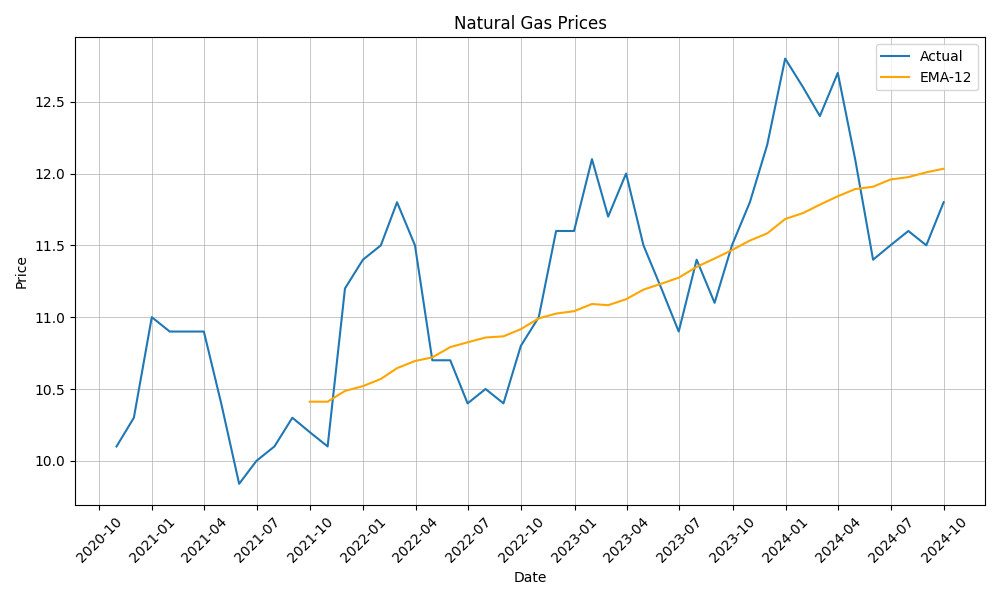

In [5]:
df['EMA12'] = df['Prices'].rolling(window=12).mean()
ax.plot(df['Dates'], df['EMA12'], label='EMA-12', color='orange')
ax.legend()
plt.show()

## Insights

Natural gas prices exhibit distinct seasonal patterns throughout the year. Prices consistently trend lower during the warmer months from April through October, when demand for heating decreases. Conversely, prices rise significantly during the winter months of November through March, driven by increased heating demand in homes and businesses.

The 12-period Exponential Moving Average (EMA-12) reveals an underlying stability in the market despite these seasonal fluctuations. This stability suggests that while short-term price movements are influenced by seasonal factors, the broader market fundamentals remain relatively constant over time.

## Make Predictions

To address the seasonal fluctuation, we will use fbprophet model to predict to create predictions. At the end of this section, we will assess its accuracy and improve the model further if needed.

In [6]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = pd.to_datetime(df["Dates"])  # Convert dates to datetime
df_prophet['y'] = df["Prices"]  # Values must be named 'y'

In [13]:
m = Prophet()
m.fit(df_prophet)

future = m.make_future_dataframe(periods=36, freq='ME')

# Make predictions
forecast = m.predict(future)
forecast[['ds', 'yhat']]
forecast

18:54:34 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-31,10.181210,9.745203,10.093929,10.181210,10.181210,-0.251702,-0.251702,-0.251702,-0.251702,-0.251702,-0.251702,0.0,0.0,0.0,9.929508
1,2020-11-30,10.223802,10.298965,10.671035,10.223802,10.223802,0.256567,0.256567,0.256567,0.256567,0.256567,0.256567,0.0,0.0,0.0,10.480370
2,2020-12-31,10.267815,10.725603,11.098410,10.267815,10.267815,0.645077,0.645077,0.645077,0.645077,0.645077,0.645077,0.0,0.0,0.0,10.912891
3,2021-01-31,10.311827,10.776637,11.115809,10.311827,10.311827,0.639250,0.639250,0.639250,0.639250,0.639250,0.639250,0.0,0.0,0.0,10.951076
4,2021-02-28,10.351580,10.719591,11.073332,10.351580,10.351580,0.548535,0.548535,0.548535,0.548535,0.548535,0.548535,0.0,0.0,0.0,10.900115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2027-05-31,13.113105,12.515034,13.084399,12.894726,13.309239,-0.307694,-0.307694,-0.307694,-0.307694,-0.307694,-0.307694,0.0,0.0,0.0,12.805411
80,2027-06-30,13.141804,12.143100,12.707639,12.910886,13.346872,-0.712957,-0.712957,-0.712957,-0.712957,-0.712957,-0.712957,0.0,0.0,0.0,12.428846
81,2027-07-31,13.171459,12.462046,13.062275,12.931010,13.386617,-0.403044,-0.403044,-0.403044,-0.403044,-0.403044,-0.403044,0.0,0.0,0.0,12.768415
82,2027-08-31,13.201115,12.209853,12.807474,12.946747,13.426689,-0.687519,-0.687519,-0.687519,-0.687519,-0.687519,-0.687519,0.0,0.0,0.0,12.513596


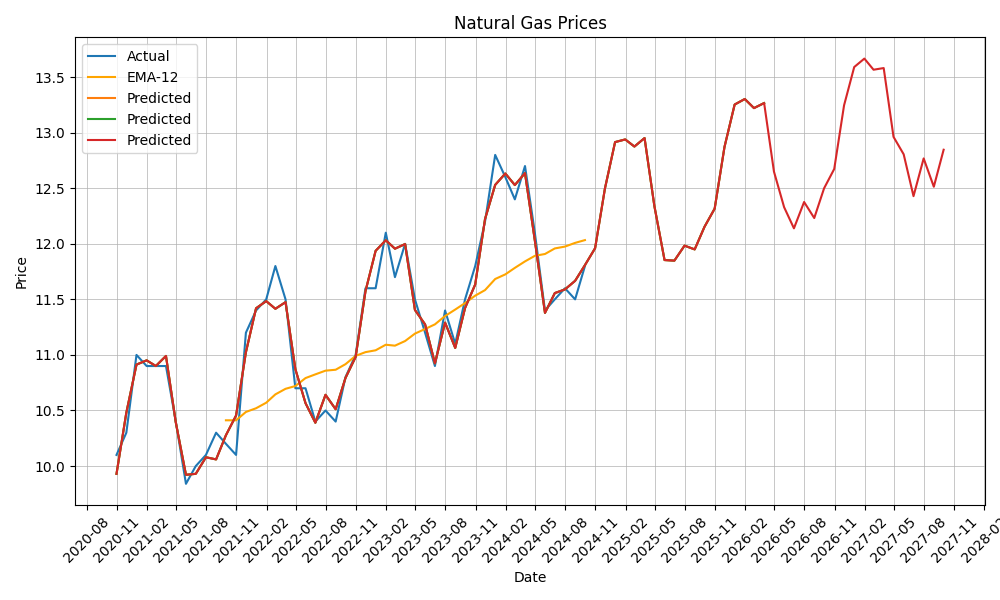

In [14]:
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted', markersize=8)

ax.legend()

plt.show()

## Model's Statistics

In [15]:
cost = 0

for i in range(len(df['Dates'])):
    error = (abs(df['Prices'].iloc[i] - forecast['yhat'].iloc[i])/df['Prices'].iloc[i])*100
    cost = cost + error

cost = cost/len(df['Dates'])
print(f'cost: {cost:.3f}%')

cost: 0.893%


#### The total error of the function is approximately 0.9%, which is good enough!

In [16]:
forecast = forecast.rename(columns={'ds': 'Dates', 'yhat': 'Prices'})

# Write to CSV with specific formatting
forecast.to_csv('forecast_output.csv', 
               index=False,  # Don't write row numbers
               float_format='%.2E',  # Use scientific notation with 2 decimal places
               date_format='%m-%d-%Y')  # Format dates as MM/DD/YYYY